In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import csv

<h1>Text preprocessing</h1>
Code adapted from: https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639

In [2]:
import re
import string

def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = text.replace("i'm", "i am")
    # text = re.sub(r"i'm", "i am", text)
    text = text.replace("he's", "he is")
    text = text.replace("she's", "she is")
    text = text.replace("it's", "it is")
    text = text.replace("what's", "that is")
    text = text.replace("that's", "that is")
    text = text.replace("where's", "where is")
    text = text.replace("how's", "how is")
    text = text.replace("\'ll", " will")
    text = text.replace("\'re", " are")
    text = text.replace("\'ve", " have")
    text = text.replace("\'d", " would")
    text = text.replace("won't", "will not")
    text = text.replace("can't", "cannot")
    text = text.replace("n't", " not")
    text = text.replace("n'", "ng")
    text = text.replace("'bout", "about")
    text = text.replace("'til", "until")
    text = re.sub(' +', ' ', text)
    text = re.sub(r"[<>]", repl="", string=text)
    # if text != ":)" or text != ":(":
    #     text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

start_char = "<START>"
end_char = "<END>"

posts = []
comments_output = []
comments_input = []
with open('../splitted_data_2.csv', 'r', newline='') as csv_file:
    textReader = csv.reader(csv_file)
    for row in textReader:
        cleaned_text = clean_text(row[1])
        posts.append(" ".join(re.findall(r"[\w']+|[.,!?;]", cleaned_text)))

        cleaned_text = clean_text(row[0])
        cleaned_text = re.findall(r"[\w']+|[.,!?;]", cleaned_text)
        cleaned_text = [ x.strip() for x in cleaned_text ]
        cleaned_text = [start_char] + cleaned_text + [end_char]
        comments_output.append(" ".join(cleaned_text[1:]))
        comments_input.append(" ".join(cleaned_text[:-1]))
print("Num samples posts: ", len(posts))
print("Num samples comments output", len(comments_output))
print("Num samples comments input", len(comments_input))
print(posts[500])
print(comments_output[500])
print(comments_input[500])

Num samples posts:  2532
Num samples comments output 2532
Num samples comments input 2532
please , i just need something . please .
absolutely you will be okay . just remember that everything that has happened thus far in life has been okay , so it stands to reason that this will be okay too . relax . everything is in control . there's always a way . <END>
<START> absolutely you will be okay . just remember that everything that has happened thus far in life has been okay , so it stands to reason that this will be okay too . relax . everything is in control . there's always a way .


In [3]:
# Generate all the unique words in the data set
all_words = set()
all_text = posts + comments_output + comments_input
for sentence in all_text:
    for word in sentence.split():
        all_words.add(word)
print("Total number of unique words: ", len(all_words))

for i, word in enumerate(all_words):
    if i < 5:
        print(word)
    else: break

Total number of unique words:  8316
flirting
bmi
unthink
compassion
brushed


In [4]:
from keras.preprocessing.text import Tokenizer
from scipy import stats

vocab_size = len(all_words)
tokenizer = Tokenizer(num_words = vocab_size+1, filters='', lower=False)
tokenizer.fit_on_texts(all_text)
word_to_index = tokenizer.word_index
index_to_word = {v:k for k,v in word_to_index.items()}
print("Total unique words: ", len(word_to_index))

posts_sequence = tokenizer.texts_to_sequences(posts)
MAX_POST_LEN = max(len(seq) for seq in posts_sequence)
average_post_length = np.average([len(seq) for seq in posts_sequence])
median_post_length = np.median([len(seq) for seq in posts_sequence])
print("Max post length: ", MAX_POST_LEN)
print("Average post length: ", average_post_length)
print("median_post_length: ", median_post_length)

comments_output_sequence = tokenizer.texts_to_sequences(comments_output)
comments_input_sequence = tokenizer.texts_to_sequences(comments_input)
MAX_COMMENT_LEN = max(len(seq) for seq in comments_output_sequence)
average_comment_length = np.average([len(seq) for seq in comments_output_sequence])
median_comment_length = np.median([len(seq) for seq in comments_output_sequence])
print("Max comment length: ", MAX_COMMENT_LEN)
print("Average comment length: ", average_comment_length)
print(np.average([len(seq) for seq in comments_input_sequence]))
print("median_comment_length: ", median_comment_length)

AVG_POST_LEN = 203 #int(round(average_post_length))
print(AVG_POST_LEN)
AVG_COMMENT_LEN = 150 #int(round(average_comment_length))
print(AVG_COMMENT_LEN)

# index_to_word = dict()
# for k, v in word_to_index.items():
#     index_to_word[v] = k

Total unique words:  8316
Max post length:  373
Average post length:  121.51382306477093
median_post_length:  129.0
Max comment length:  209
Average comment length:  69.35031595576619
69.35031595576619
median_comment_length:  68.0
203
150


In [5]:
# Truncate the output to the average length of a comment (203)
truncated = []
for comment in comments_input_sequence:
    if len(comment) > AVG_COMMENT_LEN:
        truncated.append(comment[:AVG_COMMENT_LEN])
    else:
        truncated.append(comment)
comments_input_sequence = truncated.copy()
print(comments_input_sequence[:5])
truncated = []

for comment in comments_output_sequence:
    if len(comment) > AVG_COMMENT_LEN:
        truncated.append(comment[:AVG_COMMENT_LEN-1] + [word_to_index['<END>']])
    else:
        truncated.append(comment)
comments_output_sequence = truncated.copy()
print(comments_output_sequence[:5])

print(np.average([len(seq) for seq in comments_output_sequence]))
print(np.average([len(seq) for seq in comments_input_sequence]))
print(max([len(seq) for seq in comments_output_sequence]))
print(max([len(seq) for seq in comments_input_sequence]))



[[39, 20, 221, 11, 422, 619, 15, 80, 187, 115, 5, 66, 10, 6, 25, 188, 1281, 14, 37, 1255, 2126, 157, 1, 6, 17, 3, 50, 8, 991, 3, 91, 209, 8, 5104, 12, 5105, 4, 18, 42, 8, 202, 47, 4, 291, 5106, 3, 22, 7, 311, 967, 14, 23, 511, 5, 5107, 72, 1], [39, 613, 30, 51, 3, 1322, 8, 1991, 1, 2638, 76, 1474, 4, 2639, 4, 13, 440, 1410, 7, 2640, 594, 10, 1168, 944, 24, 285, 8, 1644, 3, 2147, 944, 11, 262, 2641, 4, 74, 27, 2530, 1674, 1, 23, 528, 31, 87, 9, 11, 2407, 5, 31, 2642, 172, 2270, 1, 1443, 3, 98, 3, 547, 315, 944, 29, 7, 1168, 1003, 127, 102, 66, 37, 180, 1267, 88, 1, 811, 29, 23, 661, 30, 55, 77, 3, 288, 2643, 15, 8, 235, 1], [39, 107, 4, 2, 188, 752, 3, 136, 217, 724, 5, 99, 333, 70, 133, 12, 7, 1049, 6, 87, 6, 24, 4, 6, 24, 7, 797, 3, 20, 198, 1, 67, 11, 7, 140, 12, 51, 10, 6, 17, 1095, 5, 31, 585, 3, 20, 198, 1, 81, 53, 6, 25, 82, 3, 97, 7, 182, 47, 3, 97, 125, 12, 72, 1, 172, 2550, 5, 117, 6, 17, 11, 775, 14, 23, 661, 15, 20, 198, 1], [39, 4236, 355, 330, 3512, 60, 58, 33, 16, 4237, 1

In [6]:
#PADDING

padded_post_sequences = pad_sequences(posts_sequence, maxlen=AVG_POST_LEN, truncating='post')
padded_comment_input_sequences = pad_sequences(comments_input_sequence, maxlen=AVG_COMMENT_LEN, padding='post')
padded_comment_output_sequences = pad_sequences(comments_output_sequence, maxlen=AVG_COMMENT_LEN, padding='post')
print("padded_post_sequences.shape", padded_post_sequences.shape)
print("padded_post_sequences[500]", padded_post_sequences[500])
print(word_to_index['we'])
print(padded_comment_input_sequences.shape)
print(padded_comment_input_sequences[500])
# print(word_to_index['<'])

# encoder_sequences = tokenizer.texts_to_sequences(posts)
# encoder_sequences_padded = pad_sequences(encoder_sequences, maxlen=max_source_length, dtype='int32', padding='post', truncating='post')
# decoder_sequences = tokenizer.texts_to_sequences(comments)
# decoder_sequences_padded = pad_sequences(decoder_sequences, maxlen=max_target_length, dtype='int32', padding='post', truncating='post')

padded_post_sequences.shape (2532, 203)
padded_post_sequences[500] [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0 164   4   2  25
  82  83   1 164   1]
65
(2532, 150)
[  39  436    6   31   22  260    1   25  263   10  143   10  108  374
 2097  281   15   59  

In [7]:
# Layer will consider the top 20000 words and will pad or truncate words to be 200 words long 
# vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
# text_ds = tf.data.Dataset.from_tensor_slices(comments).batch(128)
# vectorizer.adapt(text_ds)
# print(vectorizer.get_vocabulary()[:5])

#dict mapping words to their indices
# voc = vectorizer.get_vocabulary()
# word_index = dict(zip(voc, range(len(voc))))

embeddings_dictionary = {}
with open('./glove6B/glove.6B.200d.txt', 'r') as glove:
    for line in glove:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

print("Found %s word vectors." % len(embeddings_dictionary))

Found 400000 word vectors.


In [8]:
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_to_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

print(embeddings_dictionary["we"])
print(embedding_matrix.shape)

Converted 7786 words (530 misses)
[ 0.19495    0.6061    -0.077356   0.017301  -0.5137     0.22422
 -0.80773    0.022378   0.30256    1.0667    -0.10918    0.57903
  0.23986    0.1691     0.0072384  0.42198   -0.20459    0.60271
  0.19188   -0.19616    0.3307     3.2002    -0.18104    0.20784
  0.49511   -0.42259    0.022125   0.24379    0.16714   -0.2091
 -0.12489   -0.51767   -0.13569   -0.2598    -0.17961   -0.47663
 -0.8954    -0.27139    0.17746    0.45827    0.21363    0.22343
 -0.049342   0.34286   -0.32315    0.2747     0.95993   -0.25979
  0.2125    -0.21373    0.19809    0.15455   -0.48581    0.38925
  0.33747   -0.27898    0.19371   -0.45872   -0.054217  -0.24023
  0.59153    0.12453   -0.21302    0.058223  -0.046671  -0.011614
 -0.32026    0.6412    -0.28719    0.035138   0.39287   -0.030683
  0.083529  -0.010964  -0.62427   -0.13575   -0.38469    0.11454
 -0.61038    0.12595   -0.17633   -0.21415   -0.37014    0.21763
  0.055366  -0.25242   -0.45476   -0.28105    0.18911  

<h1>Embedding Layer</h1>
The size of the embedding layer is the size of the vector that represents each word. We usually match the size of the embedding layer output with the number of hidden layers in the LSTM cell. 

The size of the hidden layer is equal to the number nodes representing the signmoid, tanh and hidden state layer in the LSTM cell. 

In [9]:
from keras.initializers import Constant
# embedding_layer = Embedding(vocab_size+1, embedding_dim, embeddings_initializer=Constant(embedding_matrix),  trainable=False)
print(vocab_size+1)
embedding_layer = Embedding(vocab_size+1, embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=AVG_POST_LEN, trainable=False)


8317


CREATING THE MODEL

In [10]:
"""
decoder_targets_one_hot = np.zeros((
    len(posts),
    AVG_COMMENT_LEN,
    vocab_size+1
    ), 
    dtype='float32' 
)
print(decoder_targets_one_hot.shape)

# # One-hot encoding of the output
# num_samples = len(encoder_sequences)
# decoder_output_data = np.zeros((num_samples, max_target_length, vocab_size), dtype='float32')
for i, seqs in enumerate(padded_comment_output_sequences):
    # print("A: ",seqs)
    for j, seq in enumerate(seqs):
        # print("B: ", seq)
        # print(index_to_word[seq])
        decoder_targets_one_hot[i, j, seq] = 1
        # if j > 0:
            
        #     break
    # break
"""
decoder_targets_glove = np.zeros((
    len(posts), 
    AVG_COMMENT_LEN, 
    embedding_dim
    ), 
    dtype='float32'
)
for i, seqs in enumerate(padded_comment_output_sequences):
    # print("A: ",seqs)
    for j, seq in enumerate(seqs):
        word_embedding = embedding_matrix[seq]
        decoder_targets_glove[i, j] = word_embedding
    #     print("B: ", seq)
    #     print(word_embedding)
    #     print(index_to_word[seq])
    #     print(decoder_targets_glove[i, j])
    #     print(decoder_targets_glove)
    #     break
    # break
        # decoder_targets_one_hot[i, j, seq] = 1

In [11]:
# Defining the encoder

latent_dim = 200 #LSTM_NODES = latent_dim. Either set to 256 or 50???

encoder_inputs = Input(shape=(AVG_POST_LEN,)) # shape=(None,), dtype="int64"
enc_emb = embedding_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [12]:
# Defining the decoder

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(AVG_COMMENT_LEN,)) 

# dec_emb_layer = Embedding(vocab_size+1, latent_dim)
# dec_emb = dec_emb_layer(decoder_inputs)
dec_embedding_layer = Embedding(vocab_size+1, 200, embeddings_initializer=Constant(embedding_matrix), input_length=AVG_COMMENT_LEN, trainable=False)
dec_emb = dec_embedding_layer(decoder_inputs)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
# print(decoder_outputs.shape)

In [13]:
# Output from the decoder LSTM

decoder_dense = Dense(embedding_dim, use_bias=False)
# Distribution over all vocab
# decoder_dense = Dense(vocab_size+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [14]:
# from keras.optimizers import SGD

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
lossClass = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
def my_loss_fn(y_true, y_pred):
    # print("yTrue: ")
    # tf.print(y_true)
    # tf.print(y_true.shape)
    # print("yPred: ")
    # tf.print(y_pred)
    # tf.print(y_pred.shape)
    return tf.keras.losses.mean_squared_error(y_true, y_pred)  # Note the `axis=-1`
# lossClass = tf.keras.losses.MeanAbsolutePercentageError()
model.compile(
    optimizer="sgd",
    loss="mean_squared_error",
    metrics=['accuracy']
)

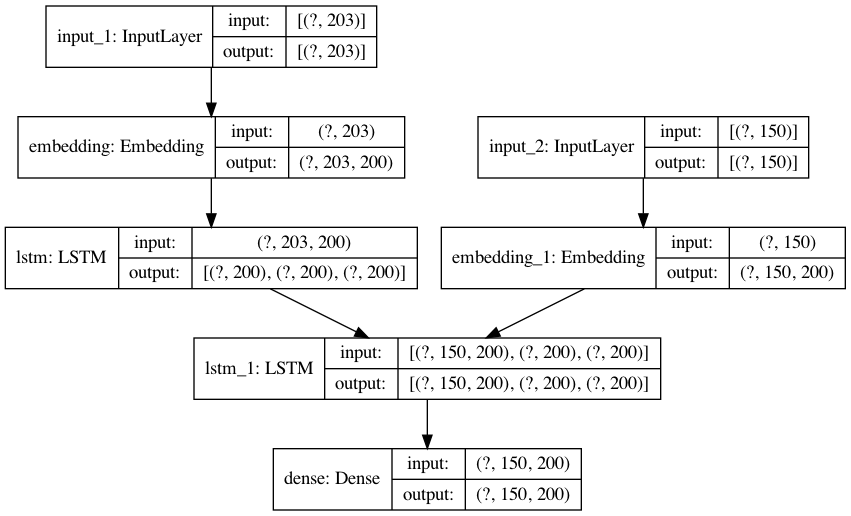

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='../LSTM/model.png', show_shapes=True, show_layer_names=True)

In [16]:
print(encoder_inputs.shape, decoder_inputs.shape)
print(decoder_inputs.shape)
print(padded_post_sequences.shape)

print(padded_post_sequences[0:1].shape)
print(padded_comment_input_sequences.shape)

(None, 203) (None, 150)
(None, 150)
(2532, 203)
(1, 203)
(2532, 150)


In [17]:
from keras.callbacks import CSVLogger

# csv_logger = CSVLogger('training_log.csv', append=True)
# with open('training_log.csv', mode='a') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow([
#         f'epochs:', 
#         f'latent_dim: ', 
#         f'optimizer:', 
#         f'activation:', 
#         'blank'
#     ])

r = model.fit(
    x=[padded_post_sequences, padded_comment_input_sequences],
    y=decoder_targets_glove,
    batch_size=64,
    epochs=1,
    validation_split=0.1,
    #callbacks=[csv_logger] #for printing
)
#x=[padded_post_sequences[0:1], padded_comment_input_sequences[0:1]],
    #y=decoder_targets_glove[0:1],
    # x=[padded_post_sequences, padded_comment_input_sequences],
    # y=decoder_targets_glove,
model.save("s2s")
#model.save_weights('saved_weights.hdf5', overwrite=True)

36/36 [==============================] - 29s 793ms/step - loss: 0.0907 - accuracy: 3.1899e-04 - val_loss: 0.0907 - val_accuracy: 3.6745e-04
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: s2s/assets


In [ ]:
print(padded_comment_output_sequences[0:1])
number = padded_comment_output_sequences[0:1]
print()
print(embedding_matrix[padded_comment_output_sequences[0:1][0]])

In [ ]:
# Run overnight
# Increase word embeddings to 200
parameters = [
    {'epochs': 100, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 300, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 400, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 500, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 600, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 700, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 800, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 900, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 1000, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 64, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 128, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 320, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 448, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 512, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 640, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 704, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 832, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 960, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 1024, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'rmsprop', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'adagrad', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'adamax', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'nadam', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'ftrl', 'activation': 'softmax'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'relu'}, 
    {'epochs': 200, 'latent_dim': 256, 'optimizer': 'adam', 'activation': 'sigmoid'}
]

In [9]:
model = keras.models.load_model("model-200-256-adam-mean_squared_error")
model.summary()
# for idx, layer in enumerate(model.layers):
#     print(idx, layer.name)
# return
latent_dim = 256
"""
encoder_inputs = Input(shape=(AVG_POST_LEN,)) # shape=(None,), dtype="int64"
enc_emb = embedding_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(AVG_COMMENT_LEN,)) 
dec_emb_layer = Embedding(vocab_size+1, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
"""
def my_loss_fn(y_true, y_pred):
    # print("yTrue: ")
    # tf.print(y_true)
    # tf.print(y_true.shape)
    # print("yPred: ")
    # tf.print(y_pred)
    # tf.print(y_pred.shape)
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

encoder_inputs = model.input[0]  # input_1
# for i in range(6):
#     print(i)
#     print(model.layers[i].output)
# embedding_layer = model.layers[2]
# enc_emb = embedding_layer(encoder_inputs)
encoder_outputs, state_h_enc, state_c_enc = model.layers[4].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)


# for i in range(4):
#     print(model.input[i])

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
dec_emb_layer = model.layers[3]
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    dec_emb, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)
from keras.utils import plot_model
plot_model(encoder_model, to_file='../LSTM/encoder_inference_model.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='../LSTM/decoder_inference_model.png', show_shapes=True, show_layer_names=True)

def give_encouragement(input_seq):
    #Marathi one
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = word_to_index['<START>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        print(output_tokens[0, 0])
        print(output_tokens.shape)
        # Sample a token
        break
        
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_word[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<END>' or len(decoded_sentence) > AVG_COMMENT_LEN):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 203)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 203, 200)     1663400     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 150, 200)     1663400     input_8[0][0]                    
_______________________________________________________________________________________

In [11]:
# for _ in range(5):
# for seq_index in range(2):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index : seq_index + 1]
import math

def give_encouragement(input_seq):
    #Marathi one
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = word_to_index['<START>']
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # 
        # print(output_tokens.shape)
        # print(embedding_matrix[5:6])
        # print(embedding_matrix[5:6].shape)
        # print(output_tokens[0, -1, :])
        # print(output_tokens[0,-1, :].shape)
        similarity = math.inf
        idx = 0
        for i in range(7786):
            new_sim = tf.keras.losses.cosine_similarity(embedding_matrix[i:i+1][0].astype('float32'), output_tokens[0, 0].astype('float32'), axis=-1)
            if new_sim < similarity:
                similarity = new_sim
                idx = i        
        print(idx)
        sampled_char = index_to_word[idx]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<END>' or len(decoded_sentence) > AVG_COMMENT_LEN):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]

    return decoded_sentence
for _ in range(1):
    i = np.random.choice(len(posts))
    input_seq = padded_post_sequences[i:i+1]
    generated_comment = give_encouragement(input_seq)
    print('-')
    print('Post: ', posts[i])
    print('Generated Comment: ', generated_comment)
    print("Actual Comment: ", comments_input[i])

6
6
36
1
1893
1
5
1
6
24
18
28
28
28
18
18
6
6
34
6
62
6
3
13
461
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
26
1
2
26
16
18
8
-
Post:  it is now week 3 of my first ever internship and every day i come home feeling worse about myself and how things are going . i try to ask questions but a lot of times i feel like im so confused i dont know where to start or my manager is not there and i dont even know who to go to for questions . when he is there and i ask questions he always seems to answer in a way that makes me feel stupid and like i should have just figured out the answer on my own . i am currently working on 3 projects and a couple side projects for my managers boss . not sure if that is normal or not but i am feeling very overwhelmed and anxious . im just tired of coming back to my apartment everyday feeling like ive accomplished nothing again , i am constantly wondering why i was hired for this position when i know so many others that would probably do better . i just want to feel like

In [43]:
print(embedding_matrix[word_to_index['<']])
# print(encoder_inputs.shape, encoder_states[0].shape, encoder_states[1].shape)
# print(decoder_state_input_h.shape)
# print(decoder_state_input_c.shape)
# print(decoder_inputs_single.shape)
# print(decoder_outputs.shape)
# for i in decoder_states_inputs:
#     print(i.shape)

KeyError: '<'

In [ ]:
from keras.utils import plot_model
# # Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)
plot_model(encoder_model, to_file='../LSTM/model_plot_enc.png', show_shapes=True, show_layer_names=True)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = dec_emb_layer(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

# dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
# decoder_states2 = [state_h2, state_c2]
# decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

# # Encode the input sequence to get the "thought vectors"
# encoder_model = Model(encoder_inputs, encoder_states)

# # Decoder setup
# # Below tensors will hold the states of the previous time step
# decoder_state_input_h = Input(shape=(latent_dim,))
# decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# # To predict the next word in the sequence, set the initial states to the states from the previous time step
# decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
# decoder_states2 = [state_h2, state_c2]
# decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# # Final decoder model
# decoder_model = Model(
#     [decoder_inputs] + decoder_states_inputs,
#     [decoder_outputs2] + decoder_states2)


plot_model(decoder_model, to_file='../LSTM/model_plot_dec.png', show_shapes=True, show_layer_names=True)
encoder_model.save_weights('encoder_model_weights.hdf5', overwrite=True)
decoder_model.save_weights('decoder_model_weights.hdf5', overwrite=True)

Keras LSTM Architecture

The input shape of the text data is ordered as follows: batch size, number of time steps, hidden size (size of the hidden layer)
For each batch sample and each word in the number of time steps, there is a l500 length embedding word vector to 

In [ ]:
# encoder_model.load_weights("../LSTM/encoder_model_weights.hdf5")
    # decoder_model.load_weights("../LSTM/decoder_model_weights.hdf5")
    
    # # KERAS
    # states_value = encoder_model.predict(input_seq)

    # # Generate empty target sequence of length 1.
    # target_seq = np.zeros((1, 1, vocab_size))
    # # Populate the first character of target sequence with the start character.
    # target_seq[0, 0, word_to_index['<START>']] = 1.0

    # # Sampling loop for a batch of sequences
    # # (to simplify, here we assume a batch of size 1).
    # stop_condition = False
    # decoded_sentence = ""
    # while not stop_condition:
    #     output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    #     # Sample a token
    #     sampled_token_index = np.argmax(output_tokens[0, -1, :])
    #     sampled_char = index_to_word[sampled_token_index]
    #     decoded_sentence += sampled_char

    #     # Exit condition: either hit max length
    #     # or find stop character.
    #     if sampled_char == "<END>" or len(decoded_sentence) > AVG_COMMENT_LEN:
    #         stop_condition = True

    #     # Update the target sequence (of length 1).
    #     target_seq = np.zeros((1, 1, word_to_index['<START>']))
    #     target_seq[0, 0, sampled_token_index] = 1.0

    #     # Update states
    #     states_value = [h, c]
    # return decoded_sentence

    # # The french one
    # print(input_seq.shape)
    # states_value = encoder_model.predict(input_seq)
    # target_seq = np.zeros((1, 1))
    # target_seq[0, 0] = word_to_index['<START>']
    # eos = word_to_index['<END>']
    # output_sentence = []
    # for _ in range(AVG_COMMENT_LEN):
    #     # print(states_value)
    #     # print(target_seq.shape)
    #     # inputs = [target_seq] + states_value
    #     # print(inputs)
    #     # print(states_value)
    #     # for i in range(len(states_value)):
    #     #     states_value[i] = np.asarray(states_value[i])
    #     # print(states_value)
    #     # temp = [target_seq]
    #     # print(temp)
    #     # temp.append(states_value)
    #     # for i in [target_seq] + states_value:
    #         # print(i.shape)
    #     output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    #     idx = np.argmax(output_tokens[0, 0, :])

    #     if eos == idx:
    #         break

    #     word = ''

    #     if idx > 0:
    #         word = index_to_word[idx]
    #         output_sentence.append(word)

    #     target_seq[0, 0] = idx
    #     states_value = [h, c]

    # return ' '.join(output_sentence)

    # The weird one
    # #Getting the output states to pass into the decoder
    # states_value = encoder_model.predict(input_seq)
    # #Generating empty target sequence of length 1
    # target_seq = np.zeros((1, 1, vocab_size+1))
    # #Setting the first token of target sequence with the start token
    # target_seq[0, 0, word_to_index['<START>']] = 1.
    
    # #A variable to store our response word by word
    # decoded_sentence = ''
    
    # stop_condition = False
    # while not stop_condition:
    #   #Predicting output tokens with probabilities and states
    #   output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
    #   #Choosing the one with highest probability
    #   sampled_token_index = np.argmax(output_tokens[0, -1, :])
    #   sampled_token = index_to_word[sampled_token_index]
    #   decoded_sentence += " " + sampled_token#Stop if hit max length or found the stop token
    #   if (sampled_token == '<END>' or len(decoded_sentence) > AVG_COMMENT_LEN):
    #       stop_condition = True
    #   #Update the target sequence
    #   target_seq = np.zeros((1, 1, vocab_size+1))
    #   target_seq[0, 0, sampled_token_index] = 1.
    #   #Update states
    #   states_value = [hidden_state, cell_state]
    # return decoded_sentence